# CANDLE and DLHub

This notebook shows how DLHub can be used to work with ECP-CANDLE models. We first use the DLHubClient to discover existing models. Then we use the client to initiate a publication request of a pre-trained P1B1 model. Finally, we perform on-demand inference of both the P1B1 and Combo models that are published in DLHub.

In [72]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Use the DLHub SDK to create a DLHubClient. The DLHubCLient wraps both our REST API and Search catalog. You can use the client to publish, discover, and use models.

In [73]:
import dlhub_sdk
dl = dlhub_sdk.DLHubClient()

DLHub uses a custom metadata schema to encode models. This metadata describes the inputs, outputs, type, and author information. While we provider helper functions to aid in its creation, you can see the structure

In [74]:
df_serv = dl.search_by_servable(servable_name="candle_p1b1_demo1")
df_serv[0]

{'datacite': {'alternateIdentifiers': [{'alternateIdentifier': 'https://github.com/ECP-CANDLE/Benchmarks/tree/release_01/Pilot1/P1B1',
    'alternateIdentifierType': 'URL'}],
  'creators': [{'affiliations': 'CANDLE',
    'familyName': 'Team',
    'givenName': 'CANDLE'}],
  'descriptions': [{'description': 'CANDLE pilot 1 benchmark 1 model.',
    'descriptionType': 'Abstract'}],
  'identifier': {'identifier': '10.YET/UNASSIGNED', 'identifierType': 'DOI'},
  'publicationYear': '2019',
  'publisher': 'DLHub',
  'resourceType': {'resourceTypeGeneral': 'InteractiveResource'},
  'titles': [{'title': 'CANDLE P1B1 Demo1'}]},
 'dlhub': {'domains': ['genomics', 'cancer research'],
  'ecr_uri': '039706667969.dkr.ecr.us-east-1.amazonaws.com/037c8768-45fd-4466-aa53-95d2044ae14f',
  'files': {'model': 'p1b1.h5'},
  'funcx_id': '642e2668-ea2c-4fef-b52c-0f47341c74b0',
  'id': '037c8768-45fd-4466-aa53-95d2044ae14f',
  'name': 'candle_p1b1_demo1',
  'owner': 'ryan_globusid',
  'publication_date': '15511

# Running models

Below shows how to use the DLHub SDK to invoke the P1B1 model published in DLHub.

I have taken a subset of the data available on the CANDLE FTP site and placed it in a local file called "pilot1.npy".

In [75]:
test_data = np.load("pilot1.npy")

In [76]:
print(test_data)
print("There are {0} entries in the dataset. Each entry has {1} values.".format(len(test_data), len(test_data[0])))

[[0.8681818  0.32765958 0.88584477 ... 0.         0.         0.        ]
 [0.8545454  0.4638298  0.8584475  ... 0.         0.         0.        ]
 [0.83181816 0.         0.9086758  ... 0.         0.         0.        ]
 ...
 [0.8454546  0.5702127  0.86757994 ... 0.         0.         0.        ]
 [0.84090906 0.4595745  0.8995434  ... 0.         0.         0.        ]
 [0.8363636  0.39148936 0.8538813  ... 0.         0.         0.        ]]
There are 10 entries in the dataset. Each entry has 60483 values.


Now we need to find the model's name. I have previously published one called: "candle_p1b1_demo1"

In [77]:
df_serv = dl.search_by_servable(servable_name="candle_p1b1_demo1")
servable_name = df_serv[0]['dlhub']['shorthand_name']
servable_name

'ryan_globusid/candle_p1b1_demo1'

In [78]:
test_data.shape

(10, 60483)

In [79]:
p1b1_preds = []
for data in test_data:
    print(len(data))
    pred = dl.run(servable_name, [data.tolist()], input_type='json')
    p1b1_preds.append(np.array(pred))
    break

60483


In [80]:
p1b1_preds

[array([[0.82595909, 0.32600409, 0.878483  , ..., 0.01652291, 0.01677323,
         0.01659214]])]

# Publishing Models

To publish a model with DLHub we first gather some metadata about the model itself. Our SDK is designed to assist the user in generating this metadata.

This example shows how to use the DLHub SDK to:
- Using the SDK to automatically extract metadata from a Keras model.
- Describing additional metadata about the model
- Publishing the model

# Publishing and Using Pilot 1: Combo

This example uses the SDK to markup, publish, and use the Combo model. The trained model is provided as two files: a set of weights and an architecture file.

The Combo model also requires a custom dropout layer. We have extended the Keras model loader to support this. However, the metadata describing the model must indicate that the custom layer is necessary and the layer needs to be shipped along with the model itself to create the servable.

In [81]:
from dlhub_sdk.models.servables.keras import KerasModel
from dropout_layer import PermanentDropout
import pickle as pkl
import json
# Describe the keras model
model_info = KerasModel.create_model('saved.weights.h5', list(map(str, range(10))), 
                                     arch_path="saved.model.h5", 
                                     custom_objects={"PermanentDropout": PermanentDropout})

Here we use the SDK to directly publish the model using the model object. This process will first take each of the files listed in "files" block and create a temporary tar file. The tar file is then transmitted to the DLHub service (via a multipart POST request) and the JSON document is used to guide a publication pipeline. 

The publication process includes:
- Creating a temporary tar of the files specified in the above JSON
- Transmit the tar file to the DLHub service using a multipart POST request
- Start a server-side flow to:
    - Use the specified dependencies to create a docker container of the model
    - Push a copy of the container to AWS ECR
    - Ingest the metadata into the search index

We could also save the above JSON document and use it to publish the model via our CLI or through our GitHub-based repo2docker pipeline.

In [82]:
# Describe the model
model_info.set_title("CANDLE Pilot1 Combo Demo3")
model_info.set_name("candle_p1_combo_demo3")
model_info.set_domains(["genomics","cancer research"])

# Add dependencies
model_info.add_requirement('keras', 'detect')
model_info.add_requirement('numpy', 'detect')

# Add dropout layer file
model_info.add_file("dropout_layer.py")

# Describe the outputs in more detail
model_info['servable']['methods']['run']['output']['description'] = 'Output'
model_info['servable']['methods']['run']['input']['description'] = 'Input'

# Add provenance information
model_info.set_authors(["Team, CANDLE"], ["CANDLE"])
model_info.set_abstract("CANDLE pilot 1 combo model.")
model_info.add_alternate_identifier("https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/Combo", "URL")

In [83]:
print(json.dumps(model_info.to_dict(), indent=2))

{
  "datacite": {
    "creators": [
      {
        "givenName": "CANDLE",
        "familyName": "Team",
        "affiliations": "CANDLE"
      }
    ],
    "titles": [
      {
        "title": "CANDLE Pilot1 Combo Demo3"
      }
    ],
    "publisher": "DLHub",
    "publicationYear": "2019",
    "identifier": {
      "identifier": "10.YET/UNASSIGNED",
      "identifierType": "DOI"
    },
    "descriptions": [
      {
        "description": "CANDLE pilot 1 combo model.",
        "descriptionType": "Abstract"
      }
    ],
    "fundingReferences": [],
    "relatedIdentifiers": [],
    "alternateIdentifiers": [
      {
        "alternateIdentifier": "https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/Combo",
        "alternateIdentifierType": "URL"
      }
    ],
    "rightsList": [],
    "resourceType": {
      "resourceTypeGeneral": "InteractiveResource"
    }
  },
  "dlhub": {
    "version": "0.8.2",
    "domains": [
      "genomics",
      "cancer research"
    ],
    "visi

In [18]:
task_id = dl.publish_servable(model_info)

In [19]:
task_id

'c3139cb6-ab0e-4ca0-a3a8-35832536d903'

## Running the Combo model

I'm not actually sure what data this thing takes, but the model summary states that there are three inputs:

input.cell.expression (InputLay (None, 942)<br>
input.drug1.descriptors (InputL (None, 3820)<br>
input.drug2.descriptors (InputL (None, 3820)<br>

Therefore we can create example input to ensure the model is running correctly.

In [84]:
servable_desc = dl.describe_servable('ryan_globusid/candle_p1_combo_demo3')
print(servable_desc['servable']['model_summary'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input.cell.expression (InputLay (None, 942)          0                                            
__________________________________________________________________________________________________
input.drug1.descriptors (InputL (None, 3820)         0                                            
__________________________________________________________________________________________________
input.drug2.descriptors (InputL (None, 3820)         0                                            
__________________________________________________________________________________________________
cell.expression (Model)         (None, 1000)         2945000     input.cell.expression[0][0]      
__________________________________________________________________________________________________
drug.descr

The servable description also contains more succinct description of the inputs

In [85]:
servable_desc['servable']['methods']['run']['input']

{'description': 'Input',
 'element_types': [{'description': 'Tensor',
   'shape': ['None', '942'],
   'type': 'ndarray'},
  {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'},
  {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'}],
 'type': 'tuple'}

The client also provides a shortcut for accessing the input descriptions, as we anticipate that being a common need

In [86]:
dl.describe_methods('ryan_globusid/candle_p1_combo_demo3', 'run')

{'input': {'description': 'Input',
  'element_types': [{'description': 'Tensor',
    'shape': ['None', '942'],
    'type': 'ndarray'},
   {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'},
   {'description': 'Tensor', 'shape': ['None', '3820'], 'type': 'ndarray'}],
  'type': 'tuple'},
 'output': {'description': 'Output',
  'shape': ['None', '1'],
  'type': 'ndarray'},
 'parameters': {}}

Given this information, we can create inputs in the proper format and use them to run the model

In [87]:
combo_input = [np.zeros((200, 942)).tolist(), 
               np.zeros((200, 3820)).tolist(), 
               np.zeros((200, 3820)).tolist()]

In [88]:
res = dl.run('ryan_globusid/candle_p1_combo_demo3', combo_input, input_type='json')

Text(0, 0.5, 'Frequency')

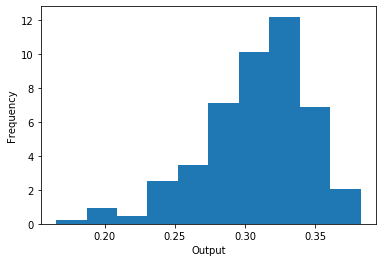

In [89]:
fig, ax = plt.subplots()

ax.hist(np.ravel(res), density=True)

ax.set_xlabel('Output')
ax.set_ylabel('Frequency')

The distribution of the outputs has a non-zero variance, as expected given that the "p1_combo" model contains a dropout layer that is still active on predictions.